#ML

In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

import pandas as pd
file_path = 'Spotify_Youtube.csv'
df = pd.read_csv(file_path)
df.drop(columns='Unnamed: 0', inplace=True)
df.info()
# normalize streams to values between 0 and 1.
min_value, max_value = df["Stream"].min(), df["Stream"].max()
df["Stream"] = (df["Stream"] - min_value) / (max_value - min_value)
print(df["Stream"])
df.dropna(subset=['Danceability',
                  'Energy',
                  'Duration_ms',
                  'Tempo',
                  'Key',
                  'Loudness',
                  'Speechiness',
                  'Acousticness',
                  'Instrumentalness',
                  'Liveness',
                  'Valence'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20718 entries, 0 to 20717
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Artist            20718 non-null  object 
 1   Url_spotify       20718 non-null  object 
 2   Track             20718 non-null  object 
 3   Album             20718 non-null  object 
 4   Album_type        20718 non-null  object 
 5   Uri               20718 non-null  object 
 6   Danceability      20716 non-null  float64
 7   Energy            20716 non-null  float64
 8   Key               20716 non-null  float64
 9   Loudness          20716 non-null  float64
 10  Speechiness       20716 non-null  float64
 11  Acousticness      20716 non-null  float64
 12  Instrumentalness  20716 non-null  float64
 13  Liveness          20716 non-null  float64
 14  Valence           20716 non-null  float64
 15  Tempo             20716 non-null  float64
 16  Duration_ms       20716 non-null  float6

# Splitting Features

In [ ]:
# normalize streams to values between 0 and 1.
min_value, max_value = df["Stream"].min(), df["Stream"].max()
df["Stream"] = (df["Stream"] - min_value) / (max_value - min_value)
print(df["Stream"])

0        0.307168
1        0.091562
2        0.018620
3        0.128349
4        0.182268
           ...   
20713    0.002723
20714    0.003216
20715    0.001837
20716    0.002028
20717    0.001680
Name: Stream, Length: 20716, dtype: float64


In [3]:
features = [ 'Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms']
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

df_scaled = pd.DataFrame(df_scaled, columns=features)
df_scaled

,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms
0,1.199398,0.325717,0.195632,0.214280,0.719417,-0.989114,-0.277514,2.489093,0.986603,0.605872,-0.016649
1,0.340189,0.316378,0.754860,0.400783,-0.591797,-0.714779,-0.286015,-0.873576,1.312555,-0.942493,-0.196691
2,0.455154,1.343735,-1.202436,0.807678,-0.395294,-0.869865,-0.046889,-0.459992,0.086160,-0.426811,-0.076671
3,0.418849,0.484491,-0.922823,0.401862,-0.629311,-1.018262,2.344223,-0.768548,0.196169,-0.007280,0.073320
4,0.261529,0.274349,1.314087,-0.206215,0.665825,-0.929944,-0.289570,-0.734132,-0.019774,1.599641,0.931202
...,...,...,...,...,...,...,...,...,...,...,...
20711,-0.228582,1.357744,-0.083981,0.286593,-0.568574,0.546521,-0.289570,-0.650466,0.522121,-1.035771,-1.042176
20712,-0.537171,1.404443,-0.363595,1.270482,0.362138,-0.920513,-0.289570,-0.600622,0.518046,1.833461,-0.591891
20713,-1.069639,0.909443,-0.363595,0.645999,-0.283644,-0.933437,-0.289570,-0.234509,-0.451661,1.614347,-0.704202
20714,-1.226958,0.615245,1.034474,0.791705,2.880955,0.225171,-0.194360,-0.507462,0.037267,1.174498,-0.932229


In [4]:
train_data,test_data = train_test_split(df_scaled,test_size=0.3,random_state=99)

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14501 entries, 4556 to 13497
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Danceability      14501 non-null  float64
 1   Energy            14501 non-null  float64
 2   Key               14501 non-null  float64
 3   Loudness          14501 non-null  float64
 4   Speechiness       14501 non-null  float64
 5   Acousticness      14501 non-null  float64
 6   Instrumentalness  14501 non-null  float64
 7   Liveness          14501 non-null  float64
 8   Valence           14501 non-null  float64
 9   Tempo             14501 non-null  float64
 10  Duration_ms       14501 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6215 entries, 19993 to 17947
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Danceability      6215 non-null   float64
 1   Energy            6215 non-null   float64
 2   Key               6215 non-null   float64
 3   Loudness          6215 non-null   float64
 4   Speechiness       6215 non-null   float64
 5   Acousticness      6215 non-null   float64
 6   Instrumentalness  6215 non-null   float64
 7   Liveness          6215 non-null   float64
 8   Valence           6215 non-null   float64
 9   Tempo             6215 non-null   float64
 10  Duration_ms       6215 non-null   float64
dtypes: float64(11)
memory usage: 582.7 KB


#Elbow Method Plot
Choosing K for model

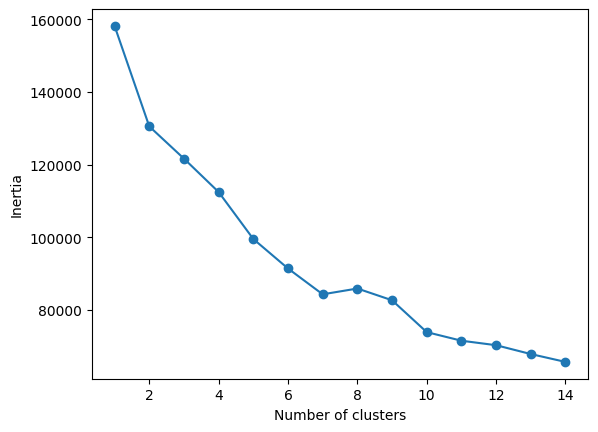

In [6]:
#Find a suitable K
inertia = []
k_value = range(1,15)

for k in k_value:
  model = KMeans(n_clusters=k, random_state=99)
  model.fit(train_data)
  inertia.append(model.inertia_)

plt.plot(k_value,inertia,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

We can easily notice the flattening of in inertia.

- From k=1 to k=4, we can see a very steep drops => shouldnt take

- From k=6 to k=14, very flat drop => should not take too

This leads us to 4 choices k=4, 5, or 6

=> Choose 5

In [7]:
optimal_k = 5
model = KMeans(n_clusters=optimal_k, random_state=99)
model.fit_predict(df_scaled)
df['Cluster'] = model.fit_predict(df_scaled)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20716 entries, 0 to 20717
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Artist            20716 non-null  object 
 1   Url_spotify       20716 non-null  object 
 2   Track             20716 non-null  object 
 3   Album             20716 non-null  object 
 4   Album_type        20716 non-null  object 
 5   Uri               20716 non-null  object 
 6   Danceability      20716 non-null  float64
 7   Energy            20716 non-null  float64
 8   Key               20716 non-null  float64
 9   Loudness          20716 non-null  float64
 10  Speechiness       20716 non-null  float64
 11  Acousticness      20716 non-null  float64
 12  Instrumentalness  20716 non-null  float64
 13  Liveness          20716 non-null  float64
 14  Valence           20716 non-null  float64
 15  Tempo             20716 non-null  float64
 16  Duration_ms       20716 non-null  float64
 17

In [9]:
df['Cluster'].value_counts()

,count
Cluster,
1,13808
0,5566
4,716
3,614
2,12


# Apply PCA
Reduce dataset dimension, mostly use to simplify a large dataset (like this one) and still keep as much important information as possible

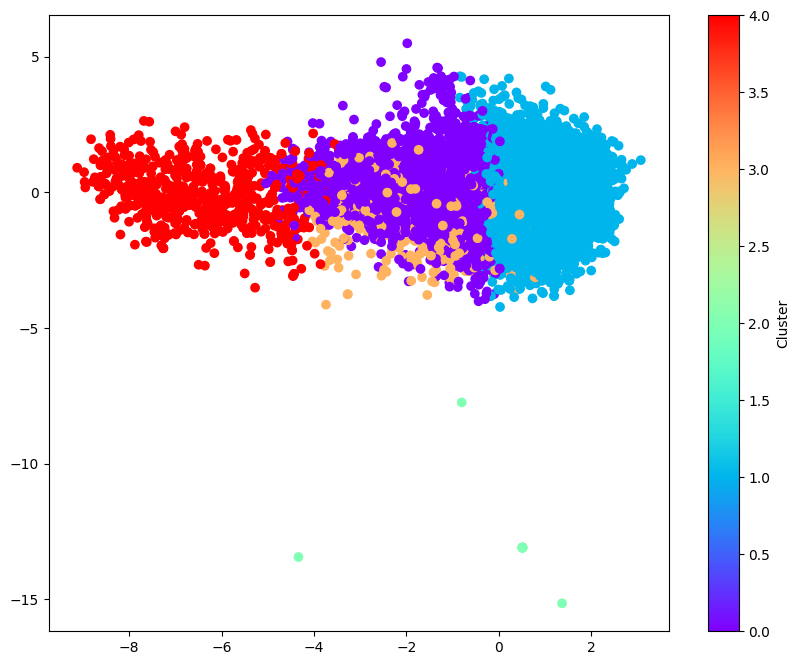

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)
# pca = PCA(n_components=2) #choose components=2 ~ 2D, easier to handle
# pca_result = pca.fit_transform(df_scaled)
plt.figure(figsize=(10,8))
plt.scatter(pca_result[:,0],
            pca_result[:,1],
            c=df['Cluster'],
            cmap='rainbow')
plt.colorbar(label='Cluster')
plt.show()

###What we can tell from this plot
1. Cluster 4 (red): Unique, seperate themselves from other types, just a little overlap with cluster 0
=> I think this might be some indie song, or 'under-ground song'

2. Cluster 0 (purple): In the middle, overlap with many other types of clusters.
=> I think it can be some types of pop

3. Cluster 3 (orange): overlap with mostly 0

4. Cluster 1 (cyan): similar to red, really distinguished

Note: outliners are green (2): might be some experimenta song ~ artists love trying new thing


=> This really helps us understand the data we have, imagine what we can do with it

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20716 entries, 0 to 20717
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Artist            20716 non-null  object 
 1   Url_spotify       20716 non-null  object 
 2   Track             20716 non-null  object 
 3   Album             20716 non-null  object 
 4   Album_type        20716 non-null  object 
 5   Uri               20716 non-null  object 
 6   Danceability      20716 non-null  float64
 7   Energy            20716 non-null  float64
 8   Key               20716 non-null  float64
 9   Loudness          20716 non-null  float64
 10  Speechiness       20716 non-null  float64
 11  Acousticness      20716 non-null  float64
 12  Instrumentalness  20716 non-null  float64
 13  Liveness          20716 non-null  float64
 14  Valence           20716 non-null  float64
 15  Tempo             20716 non-null  float64
 16  Duration_ms       20716 non-null  float64
 17

#Recommendation System With K-means

In [20]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommend_songs(song_name, df, num_recommendations=5):
    # Check if the track name is in the dataset
    if song_name not in df['Track'].values:
        raise ValueError(f"'{song_name}' not in our dataset")

    # Get cluster from the input and get the song with same cluster together
    song_cluster = df[df['Track'] == song_name]['Cluster'].values[0]
    same_cluster_songs = df[df['Cluster'] == song_cluster]

    # Calculate similarity within the same cluster
    # Get the features for similarity calculation
    cluster_features = same_cluster_songs[features]
    similarity = cosine_similarity(cluster_features, cluster_features)

    # Find index of the input song within the cluster
    song_position = same_cluster_songs[same_cluster_songs['Track'] == song_name].index
    relative_index = same_cluster_songs.index.get_indexer(song_position)[0]

    # Find the most similar songs and get recommendations Track ~ Artist ~ Album
    similar_songs = np.argsort(similarity[relative_index])[-(num_recommendations + 1):-1][::-1]
    recommendations = same_cluster_songs.iloc[similar_songs][['Track', 'Artist', 'Album']]

    return recommendations



#Example for recommendations

In [22]:
input_song = "Flashing Lights"
recommended_songs = recommend_songs(input_song, df, num_recommendations = 5)

print(f"Songs similar to '{input_song}':")
recommended_songs

Songs similar to 'Flashing Lights':


,Track,Artist,Album
8241,Feelin' Myself,will.i.am,#willpower
16147,Pork Soda,Glass Animals,How To Be A Human Being
8876,Let Me Love You,Mario,Turning Point
11898,Fuoco e benzina,Emis Killa,Supereroe
20405,grace,Fujii Kaze,grace
